In [7]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


## Beautifulsoup is used to scrape web data for San Diego zip code and corresponding neighborhoods


In [8]:
from urllib.request import urlopen
from bs4 import BeautifulSoup

url = 'http://www.sdcourt.ca.gov/portal/page?_pageid=55,1524259&_dad=portal&_schema=PORTAL'
html = urlopen(url).read()
soup = BeautifulSoup(html, "html.parser")
print(soup.prettify())

<html dir="LTR" lang="en">
 <head>
  <title>
   Zip Code Directory
  </title>
  <link href="http://www.sdcourt.ca.gov/pls/portal/PORTAL.wwv_setting.render_css?p_lang_type=NOBIDI&amp;p_subscriberid=1&amp;p_styleid=1&amp;p_siteid=55&amp;p_rctx=P&amp;p_styleid=1055025&amp;p_siteid=55&amp;p_rctx=R&amp;p_styleid=1055026&amp;p_siteid=55&amp;p_rctx=R&amp;p_styleid=1214586&amp;p_siteid=55&amp;p_rctx=R" rel="Stylesheet" type="text/css"/>
  <base href="http://www.sdcourt.ca.gov/pls/portal/"/>
  <meta content="Zip Code Directory" name="title"/>
  <meta content="" name="description"/>
  <meta content="" name="keywords"/>
  <meta content="PORTAL" name="author"/>
 </head>
 <body class="Bodyid1siteid55" leftmargin="0" marginheight="0" marginwidth="0" rightmargin="0" topmargin="0">
  <script type="text/javascript">
   function show_context_help(h) { 
    newWindow = window.open(h,"Help", "menubar=1,toolbar=1,scrollbars=1,resizable=1,width=700, height=500"); 
}
  </script>
  <noscript>
  </noscript>
  

In [9]:
table = soup.find('tbody', valign="top")
table

<tbody valign="top">
<tr>
<th width="7%">ZIP CODE</th>
<th width="19%">NAME</th>
<th width="7%">VENUE</th>
<th rowspan="59" width="1%"> </th>
<th width="7%">ZIP CODE</th>
<th width="19%">NAME</th>
<th width="7%">VENUE</th>
<th rowspan="59" width="1%"> </th>
<th width="7%">ZIP CODE</th>
<th width="19%">NAME</th>
<th width="7%">VENUE</th></tr>
<tr>
<td>91901</td>
<td>ALPINE</td>
<td><a href="/pls/portal/url/page/sdcourt/generalinformation/courtlocations/eastcountyregional">EAST</a></td>
<td>92037</td>
<td>LA JOLLA</td>
<td><a href="/pls/portal/url/page/sdcourt/generalinformation/courtlocations/familycourthouse">CENTRAL</a></td>
<td>92123</td>
<td>SD, SERRA MESA</td>
<td><a href="/pls/portal/url/page/sdcourt/generalinformation/courtlocations/familycourthouse">CENTRAL</a></td>
</tr>
<tr>
<td>91902</td>
<td>BONITA</td>
<td><a href="/pls/portal/url/page/sdcourt/generalinformation/courtlocations/southcountyregional">SOUTH</a></td>
<td>92038</td>
<td>LA JOLLA <em>(POB)</em></td>
<td><a href="/

In [10]:
table_rows = table.find_all('tr')
table1 =[]
table2 =[]
table3 =[]
for tr in table_rows:
    td = tr.find_all('td')
    row = [i.text for i in td]
    data1 = row[0:3]
    data2 = row[3:6]
    data3 = row[6:9]
    table1.append(data1)
    table2.append(data2)
    table3.append(data3)

In [11]:
df1 = pd.DataFrame(table1, columns=['Zipcode', 'Name', 'Venue'])
df2 = pd.DataFrame(table2, columns=['Zipcode', 'Name', 'Venue'])
df3 = pd.DataFrame(table3, columns=['Zipcode', 'Name', 'Venue'])
df = pd.concat([df1, df2, df3])
df.dropna(axis=0, inplace=True)
df.reset_index(drop=True, inplace=True)
df = df.applymap(str)
df.head()


,Zipcode,Name,Venue
0,91901,ALPINE,EAST
1,91902,BONITA,SOUTH
2,91903,ALPINE (POB),EAST
3,91905,BOULEVARD,EAST
4,91906,CAMPO,EAST


## Number of coronavirus cases by zip code are from SanDiegoCounty.gov - ‘tabula’ library is imported to read data from the pdf file


In [12]:
import tabula
df_Coronavirus = tabula.read_pdf("COVID-19 Summary of Cases by Zip Code.pdf", multiple_tables=True)
Covid1 = df_Coronavirus[1]
Covid2 = df_Coronavirus[2]
df_Covid19 = pd.concat([Covid1, Covid2])
df_Covid19.rename(columns={'Zip Code':'Zipcode', 'Rate per 100,000*':'Rate_per_100K'}, inplace=True)
df_Covid19 = df_Covid19[df_Covid19.Rate_per_100K != '**']
df_Covid19.reset_index(drop=True, inplace=True)
df_Covid19 = df_Covid19.applymap(str)
df_Covid19.head()

'pages' argument isn't specified.Will extract only from page 1 by default.


,Zipcode,Count,Rate_per_100K
0,91902,31,178.4
1,91910,162,195.9
2,91911,211,249.3
3,91913,93,187.8
4,91914,20,117.2


In [13]:
result = pd.merge(df_Covid19, df, on='Zipcode', how='outer')
result.dropna(axis=0, inplace=True)
result.head()

,Zipcode,Count,Rate_per_100K,Name,Venue
0,91902,31,178.4,BONITA,SOUTH
1,91910,162,195.9,CHULA VISTA,SOUTH
2,91911,211,249.3,CHULA VISTA,SOUTH
3,91913,93,187.8,CHULA VISTA,SOUTH
4,91914,20,117.2,CHULA VISTA,SOUTH


In [14]:
result['Count'] = result['Count'].astype(int)
result['Rate_per_100K'] = result['Rate_per_100K'].astype(float)
population = result['Count']/(result['Rate_per_100K']/100000)
result['Population'] = population
result = result.drop(columns = ['Venue'])
print(result.dtypes)
result.head()

Zipcode           object
Count              int64
Rate_per_100K    float64
Name              object
Population       float64
dtype: object


,Zipcode,Count,Rate_per_100K,Name,Population
0,91902,31,178.4,BONITA,17376.681614
1,91910,162,195.9,CHULA VISTA,82695.252680
2,91911,211,249.3,CHULA VISTA,84636.983554
3,91913,93,187.8,CHULA VISTA,49520.766773
4,91914,20,117.2,CHULA VISTA,17064.846416


In [15]:
#result['Address'] = df_Total[['Name', 'Zipcode']].apply(lambda x:', '.join(x), axis=1)
#result.drop(columns=['Zipcode', 'Name'], inplace=True)
result['Population'] = result['Population'].astype(int)
result

,Zipcode,Count,Rate_per_100K,Name,Population
0,91902,31,178.4,BONITA,17376
1,91910,162,195.9,CHULA VISTA,82695
2,91911,211,249.3,CHULA VISTA,84636
3,91913,93,187.8,CHULA VISTA,49520
4,91914,20,117.2,CHULA VISTA,17064
5,91915,54,181.2,CHULA VISTA,29801
6,91932,33,117.2,IMPERIAL BEACH,28156
7,91941,22,64.2,LA MESA,34267
8,91942,64,159.3,LA MESA,40175
9,91945,42,156.5,LEMON GROVE,26837


## Google geocode is used to find location data for each zip code!

In [17]:
import urllib.request, urllib.parse, urllib.error
import json
import ssl

api_key = False

if api_key is False:
    api_key = 42
    serviceurl = 'http://py4e-data.dr-chuck.net/json?'
else :
    serviceurl = 'https://maps.googleapis.com/maps/api/geocode/json?'

# Ignore SSL certificate errors
ctx = ssl.create_default_context()
ctx.check_hostname = False
ctx.verify_mode = ssl.CERT_NONE

latitude = list()
longitude = list()
location_API = list()
zipcode_API = list()
for x in result['Zipcode']:
    address = (x +','+'San Diego')
    if len(address) < 1: break

    parms = dict()
    parms['address'] = address
    if api_key is not False: parms['key'] = api_key
    url = serviceurl + urllib.parse.urlencode(parms)
 
#    print('Retrieving', url)
    uh = urllib.request.urlopen(url, context=ctx)
    data = uh.read().decode()
#    print('Retrieved', len(data), 'characters')

    try:
        js = json.loads(data)
    except:
        js = None

    if not js or 'status' not in js or js['status'] != 'OK':
        print('==== Failure To Retrieve ====')
        print(data)
        continue

#    print(json.dumps(js, indent=4))

    lat = js['results'][0]['geometry']['location']['lat']
    lng = js['results'][0]['geometry']['location']['lng']
    latitude.append(lat)
    longitude.append(lng)
#    print('lat', lat, 'lng', lng)
    location = js['results'][0]['formatted_address']
    zipcode = js['results'][0]['address_components'][0]['long_name']
    location_API.append(location)
    zipcode_API.append(zipcode)



In [18]:
df_Total = result.assign(Zipcode_API = zipcode_API, latitude = latitude, longitude = longitude, location_API = location_API)
df_Total

,Zipcode,Count,Rate_per_100K,Name,Population,Zipcode_API,latitude,longitude,location_API
0,91902,31,178.4,BONITA,17376,91902,32.670358,-117.014674,"Bonita, CA 91902, USA"
1,91910,162,195.9,CHULA VISTA,82695,91910,32.638513,-117.061755,"Chula Vista, CA 91910, USA"
2,91911,211,249.3,CHULA VISTA,84636,91911,32.605974,-117.044101,"Chula Vista, CA 91911, USA"
3,91913,93,187.8,CHULA VISTA,49520,91913,32.616875,-116.997015,"Chula Vista, CA 91913, USA"
4,91914,20,117.2,CHULA VISTA,17064,91914,32.676234,-116.944031,"Chula Vista, CA 91914, USA"
5,91915,54,181.2,CHULA VISTA,29801,91915,32.627759,-116.949919,"Chula Vista, CA 91915, USA"
6,91932,33,117.2,IMPERIAL BEACH,28156,91932,32.582989,-117.120593,"Imperial Beach, CA 91932, USA"
7,91941,22,64.2,LA MESA,34267,91941,32.769955,-116.991129,"La Mesa, CA 91941, USA"
8,91942,64,159.3,LA MESA,40175,91942,32.774949,-117.014674,"La Mesa, CA 91942, USA"
9,91945,42,156.5,LEMON GROVE,26837,91945,32.738119,-117.038216,"Lemon Grove, CA 91945, USA"


In [19]:
# comfirm geocode returns same zipcode as the requested data df_Total['Zipcode']
Comparison = np.where(df_Total['Zipcode']== df_Total['Zipcode_API'], True, False)
Comparison


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [20]:
df_Total['Address'] = df_Total[['Name', 'Zipcode']].apply(lambda x:', '.join(x), axis=1)
df_Total.drop(columns=['Zipcode', 'Name'], inplace=True)

In [21]:
df_Total

,Count,Rate_per_100K,Population,Zipcode_API,latitude,longitude,location_API,Address
0,31,178.4,17376,91902,32.670358,-117.014674,"Bonita, CA 91902, USA","BONITA, 91902"
1,162,195.9,82695,91910,32.638513,-117.061755,"Chula Vista, CA 91910, USA","CHULA VISTA, 91910"
2,211,249.3,84636,91911,32.605974,-117.044101,"Chula Vista, CA 91911, USA","CHULA VISTA, 91911"
3,93,187.8,49520,91913,32.616875,-116.997015,"Chula Vista, CA 91913, USA","CHULA VISTA, 91913"
4,20,117.2,17064,91914,32.676234,-116.944031,"Chula Vista, CA 91914, USA","CHULA VISTA, 91914"
5,54,181.2,29801,91915,32.627759,-116.949919,"Chula Vista, CA 91915, USA","CHULA VISTA, 91915"
6,33,117.2,28156,91932,32.582989,-117.120593,"Imperial Beach, CA 91932, USA","IMPERIAL BEACH, 91932"
7,22,64.2,34267,91941,32.769955,-116.991129,"La Mesa, CA 91941, USA","LA MESA, 91941"
8,64,159.3,40175,91942,32.774949,-117.014674,"La Mesa, CA 91942, USA","LA MESA, 91942"
9,42,156.5,26837,91945,32.738119,-117.038216,"Lemon Grove, CA 91945, USA","LEMON GROVE, 91945"


In [22]:
df_Total.dtypes

Count              int64
Rate_per_100K    float64
Population         int64
Zipcode_API       object
latitude         float64
longitude        float64
location_API      object
Address           object
dtype: object

## Kmean Clustering

In [23]:
df_cluster = df_Total[['Count', 'Rate_per_100K']]
df_cluster

,Count,Rate_per_100K
0,31,178.4
1,162,195.9
2,211,249.3
3,93,187.8
4,20,117.2
5,54,181.2
6,33,117.2
7,22,64.2
8,64,159.3
9,42,156.5


In [24]:
from sklearn.preprocessing import StandardScaler
X = df_cluster.values[:]
X = np.nan_to_num(X)
Clus_dataSet = StandardScaler().fit_transform(X)
Clus_dataSet

array([[-0.37083085,  0.7651684 ],
       [ 1.89081163,  0.96637515],
       [ 2.7367695 ,  1.58034318],
       [ 0.69956483,  0.87324517],
       [-0.56073976,  0.06151965],
       [ 0.02625142,  0.79736148],
       [-0.33630196,  0.06151965],
       [-0.52621087, -0.54784936],
       [ 0.19889588,  0.54556561],
       [-0.18092194,  0.51337253],
       [ 1.99439831,  2.01035075],
       [ 0.88947374,  0.67203842],
       [-0.68159088, -0.77779993],
       [-0.56073976, -0.75595463],
       [-0.68159088, -0.36963767],
       [-0.73338422, -0.80424425],
       [-0.6125331 ,  0.13165458],
       [ 0.0953092 ,  0.21903579],
       [ 1.25202711,  1.03765983],
       [ 1.23476267,  0.81345802],
       [-0.3880953 , -0.67547193],
       [ 0.16436699,  0.09831174],
       [-0.43988863, -0.73066007],
       [-0.19818638, -0.40642976],
       [-0.69885533, -0.99970224],
       [-0.66432644, -0.49955974],
       [-0.33630196, -0.39493223],
       [-0.3535664 , -0.45012037],
       [-0.56073976,

In [25]:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 12)
k_means.fit(X)
labels = k_means.labels_
print(labels)

[1 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2]


In [26]:
df_Total["Clus_km"] = labels
df_Total

,Count,Rate_per_100K,Population,Zipcode_API,latitude,longitude,location_API,Address,Clus_km
0,31,178.4,17376,91902,32.670358,-117.014674,"Bonita, CA 91902, USA","BONITA, 91902",1
1,162,195.9,82695,91910,32.638513,-117.061755,"Chula Vista, CA 91910, USA","CHULA VISTA, 91910",1
2,211,249.3,84636,91911,32.605974,-117.044101,"Chula Vista, CA 91911, USA","CHULA VISTA, 91911",1
3,93,187.8,49520,91913,32.616875,-116.997015,"Chula Vista, CA 91913, USA","CHULA VISTA, 91913",1
4,20,117.2,17064,91914,32.676234,-116.944031,"Chula Vista, CA 91914, USA","CHULA VISTA, 91914",0
5,54,181.2,29801,91915,32.627759,-116.949919,"Chula Vista, CA 91915, USA","CHULA VISTA, 91915",1
6,33,117.2,28156,91932,32.582989,-117.120593,"Imperial Beach, CA 91932, USA","IMPERIAL BEACH, 91932",0
7,22,64.2,34267,91941,32.769955,-116.991129,"La Mesa, CA 91941, USA","LA MESA, 91941",0
8,64,159.3,40175,91942,32.774949,-117.014674,"La Mesa, CA 91942, USA","LA MESA, 91942",1
9,42,156.5,26837,91945,32.738119,-117.038216,"Lemon Grove, CA 91945, USA","LEMON GROVE, 91945",1


In [27]:
# create map
map_clusters = folium.Map(location=[df_Total['latitude'][0], df_Total['longitude'][0]], zoom_start=10)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_Total['latitude'], df_Total['longitude'], df_Total['Address'], df_Total['Clus_km']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [28]:
k_means_cluster_centers = k_means.cluster_centers_
k_means_cluster_centers

array([[ 28.57407407,  71.13518519],
       [104.23529412, 198.81764706],
       [258.        , 471.9       ]])

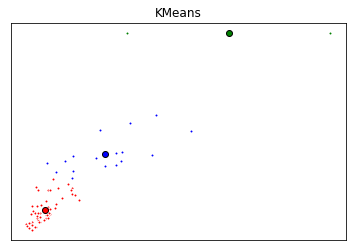

In [29]:
# Initialize the plot with the specified dimensions.
fig = plt.figure(figsize=(6, 4))

# Colors uses a color map, which will produce an array of colors based on
# the number of labels there are. We use set(k_means_labels) to get the
# unique labels.
#colors = plt.cm.Spectral(np.linspace(0, 1, len(set(labels))))
colors =('r', 'b', 'g')

# Create a plot
ax = fig.add_subplot(1, 1, 1)

# For loop that plots the data points and centroids.
# k will range from 0-2, which will match the possible clusters that each
# data point is in.
for k, col in zip(range(len([0,1,2])), colors):

    # Create a list of all data points, where the data poitns that are 
    # in the cluster (ex. cluster 0) are labeled as true, else they are
    # labeled as false.
    my_members = (labels == k)
    
    # Define the centroid, or cluster center.
    cluster_center = k_means_cluster_centers[k]
    
    # Plots the datapoints with color col.
    ax.plot(X[my_members, 0], X[my_members, 1], 'w', markerfacecolor=col, marker='.')
    
    # Plots the centroids with specified color, but with a darker outline
    ax.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,  markeredgecolor='k', markersize=6)

# Title of the plot
ax.set_title('KMeans')

# Remove x-axis ticks
ax.set_xticks(())

# Remove y-axis ticks
ax.set_yticks(())

# Show the plot
plt.show()

In [30]:
df_Total.loc[df_Total['Clus_km'] == 0]

,Count,Rate_per_100K,Population,Zipcode_API,latitude,longitude,location_API,Address,Clus_km
4,20,117.2,17064,91914,32.676234,-116.944031,"Chula Vista, CA 91914, USA","CHULA VISTA, 91914",0
6,33,117.2,28156,91932,32.582989,-117.120593,"Imperial Beach, CA 91932, USA","IMPERIAL BEACH, 91932",0
7,22,64.2,34267,91941,32.769955,-116.991129,"La Mesa, CA 91941, USA","LA MESA, 91941",0
12,13,44.2,29411,92008,33.141212,-117.320512,"Carlsbad, CA 92008, USA","CARLSBAD, 92008",0
13,20,46.1,43383,92009,33.095442,-117.249975,"La Costa, CA 92009, USA","CARLSBAD, 92009",0
14,13,79.7,16311,92010,33.159946,-117.285247,"Carlsbad, CA 92010, USA","CARLSBAD, 92010",0
15,10,41.9,23866,92011,33.105162,-117.297003,"La Costa, CA 92011, USA","CARLSBAD, 92011",0
16,17,123.3,13787,92014,32.986421,-117.226457,"Del Mar, CA 92014, USA","DEL MAR, 92014",0
17,58,130.9,44308,92019,32.775109,-116.855695,"El Cajon, CA 92019, USA","EL CAJON, 92019",0
20,30,53.1,56497,92024,33.052083,-117.279369,"Encinitas, CA 92024, USA","ENCINITAS, 92024",0


In [31]:
df_Total.loc[df_Total['Clus_km'] == 1]

,Count,Rate_per_100K,Population,Zipcode_API,latitude,longitude,location_API,Address,Clus_km
0,31,178.4,17376,91902,32.670358,-117.014674,"Bonita, CA 91902, USA","BONITA, 91902",1
1,162,195.9,82695,91910,32.638513,-117.061755,"Chula Vista, CA 91910, USA","CHULA VISTA, 91910",1
2,211,249.3,84636,91911,32.605974,-117.044101,"Chula Vista, CA 91911, USA","CHULA VISTA, 91911",1
3,93,187.8,49520,91913,32.616875,-116.997015,"Chula Vista, CA 91913, USA","CHULA VISTA, 91913",1
5,54,181.2,29801,91915,32.627759,-116.949919,"Chula Vista, CA 91915, USA","CHULA VISTA, 91915",1
8,64,159.3,40175,91942,32.774949,-117.014674,"La Mesa, CA 91942, USA","LA MESA, 91942",1
9,42,156.5,26837,91945,32.738119,-117.038216,"Lemon Grove, CA 91945, USA","LEMON GROVE, 91945",1
10,168,286.7,58597,91950,32.672160,-117.097060,"Lincoln Acres, CA 91950, USA","NATIONAL CITY, 91950",1
11,104,170.3,61068,91977,32.721529,-116.997015,"Spring Valley, CA 91977, USA","SPRING VALLEY, 91977",1
18,125,202.1,61850,92020,32.796322,-116.967581,"El Cajon, CA 92020, USA","EL CAJON, 92020",1


In [32]:
df_Total.loc[df_Total['Clus_km'] == 2]

,Count,Rate_per_100K,Population,Zipcode_API,latitude,longitude,location_API,Address,Clus_km
71,385,471.6,81636,92154,32.596720,-116.902812,"San Diego, CA 92154, USA","SD, OTAY MESA, 92154",2
72,131,472.2,27742,92173,32.549744,-117.038216,"San Ysidro, CA 92173, USA","SAN YSIDRO, 92173",2


### Extra plots

In [33]:
df_p = pd.DataFrame(columns = ['x_axis', 'y_axis'])
df_p['y_axis']= df_Total['Count'].astype(int)
df_p['x_axis'] = df_Total['Address']
df_p.sort_values(by=['y_axis'], inplace=True, ascending=False)
df_p.set_index('x_axis', inplace=True)

Text(0.5, 1.0, 'Top 10 areas have highest number of Covid19 cases in San Diego, CA')

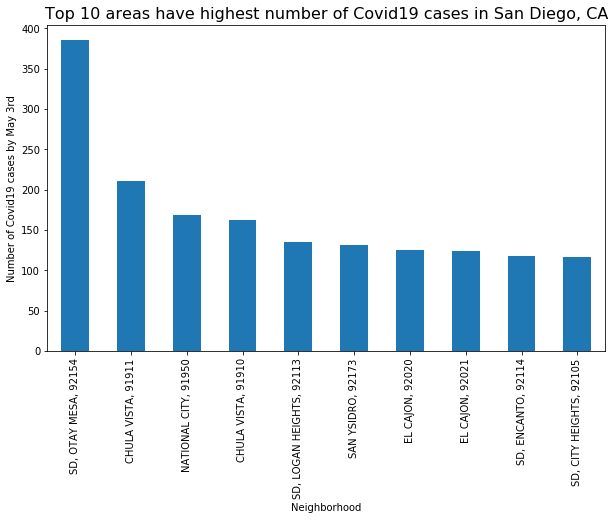

In [34]:
df_p.head(10).plot(kind='bar', legend=None, figsize=(10,6))
plt.xlabel('Neighborhood')
plt.ylabel('Number of Covid19 cases by May 3rd')
plt.title("Top 10 areas have highest number of Covid19 cases in San Diego, CA", size=16)


In [35]:
#df_Total['Count']=df_Total.Count.astype(int)
map_sd = folium.Map(location=[df_Total['latitude'][0], df_Total['longitude'][0]], zoom_start=10)


for lat, lng, Address, Count in zip(df_Total['latitude'], df_Total['longitude'], df_Total['Address'], df_Total['Count']):
    label = '{}, {}'.format(Count, Address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=Count/20,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sd)  
    
map_sd

In [364]:
df_Total['Count']=df_Total.Count.astype(float)
map_sd = folium.Map(location=[df_Total['latitude'][0], df_Total['longitude'][0]], zoom_start=10)


for lat, lng, Address, Rate_per_100K in zip(df_Total['latitude'], df_Total['longitude'], df_Total['Address'], df_Total['Rate_per_100K']):
    label = '{}, {}'.format(Rate_per_100K, Address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=Rate_per_100K/30,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_sd)  
    
map_sd

Text(0.5, 1.0, 'Top 10 areas have highest rate of Covid19 cases in San Diego, CA')

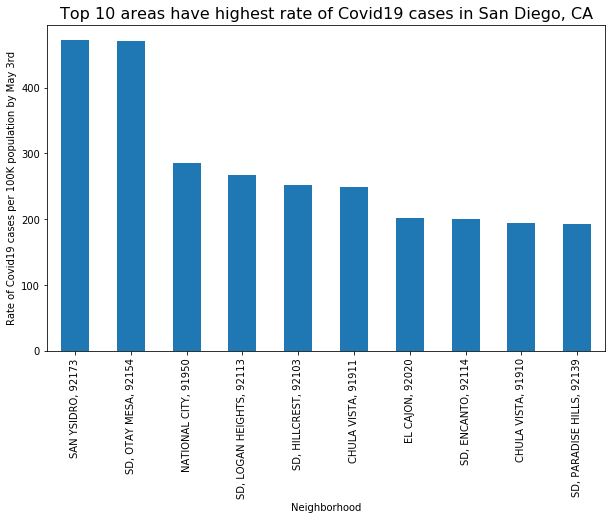

In [36]:
df_rate = pd.DataFrame(columns = ['x_axis', 'y_axis'])
df_rate['y_axis']= df_Total['Rate_per_100K'].astype(int)
df_rate['x_axis'] = df_Total['Address']
df_rate.sort_values(by=['y_axis'], inplace=True, ascending=False)
df_rate.set_index('x_axis', inplace=True)
df_rate.head(10).plot(kind='bar', legend=None, figsize=(10,6))
plt.xlabel('Neighborhood')
plt.ylabel('Rate of Covid19 cases per 100K population by May 3rd')
plt.title("Top 10 areas have highest rate of Covid19 cases in San Diego, CA", size=16)

## Call Foursquare API to find medical centers in each zip code

In [74]:
CLIENT_ID = 'IES5Y3N5UNANFLVOEAPCQ2SNFZLPTNU3UWI1JHABT0OB4BPN' # your Foursquare ID
CLIENT_SECRET = 'QBQ4020WXHKWTRTJQAAKAFS24CMRFR42LKWG1E1ZFNCZMSVG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IES5Y3N5UNANFLVOEAPCQ2SNFZLPTNU3UWI1JHABT0OB4BPN
CLIENT_SECRET:QBQ4020WXHKWTRTJQAAKAFS24CMRFR42LKWG1E1ZFNCZMSVG


In [90]:
def getNearbyVenues(search_query, Address, latitudes, longitudes, radius=5000, LIMIT=100):
    
    venues_list=[]
    for Address, lat, lng in zip(Address, latitudes, longitudes):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, search_query, radius, LIMIT)
            
   # make the GET request
        results = requests.get(url).json()
        try:
      # assign relevant part of JSON to venues
            venues = results['response']['venues']
     # return only relevant information for each nearby venue
            venues_list.append([(Address, 
                lat, 
                lng, 
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],  
                v['categories'][0]['name'],
                v['location']['postalCode']) for v in venues])
            continue
        except:
            venues_list.append([(Address, lat, lng, 'NaN', 'NaN', 'NaN',  'NaN','NaN')])
            pass
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Address', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue Zipcode']
    
    return(nearby_venues)

In [83]:
sd_clinic = getNearbyVenues(search_query = 'clinic', Address=df_Total['Address'],
                                   latitudes=df_Total['latitude'],
                                   longitudes=df_Total['longitude'],
                                  )


print(sd_clinic.shape)
sd_clinic.head(20)

(81, 8)


,Address,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Zipcode
0,"BONITA, 91902",32.670358,-117.014674,NaN,NaN,NaN,NaN,NaN
1,"CHULA VISTA, 91910",32.638513,-117.061755,NaN,NaN,NaN,NaN,NaN
2,"CHULA VISTA, 91911",32.605974,-117.044101,NaN,NaN,NaN,NaN,NaN
3,"CHULA VISTA, 91913",32.616875,-116.997015,NaN,NaN,NaN,NaN,NaN
4,"CHULA VISTA, 91914",32.676234,-116.944031,Naval Branch Health Clinic Eastlake,32.6544,-116.965,Medical Center,91914
5,"CHULA VISTA, 91914",32.676234,-116.944031,Cecil Macatangay's Clinic,32.6518,-116.968,Dentist's Office,91914
6,"CHULA VISTA, 91914",32.676234,-116.944031,Same Day STD Testing Clinic,32.6534,-116.966,Medical Lab,91914
7,"CHULA VISTA, 91914",32.676234,-116.944031,THE SKN RN acne clinic,32.6503,-116.969,Health & Beauty Service,91914
8,"CHULA VISTA, 91915",32.627759,-116.949919,Naval Branch Health Clinic Eastlake,32.6544,-116.965,Medical Center,91914
9,"CHULA VISTA, 91915",32.627759,-116.949919,Cecil Macatangay's Clinic,32.6518,-116.968,Dentist's Office,91914


In [85]:
sd_medical = getNearbyVenues(search_query='medical',
                             Address=df_Total['Address'],
                                   latitudes=df_Total['latitude'],
                                   longitudes=df_Total['longitude'],
                                  )


print(sd_medical.shape)
sd_medical.head(20)

(144, 8)


,Address,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Zipcode
0,"BONITA, 91902",32.670358,-117.014674,NaN,NaN,NaN,NaN,NaN
1,"CHULA VISTA, 91910",32.638513,-117.061755,NaN,NaN,NaN,NaN,NaN
2,"CHULA VISTA, 91911",32.605974,-117.044101,NaN,NaN,NaN,NaN,NaN
3,"CHULA VISTA, 91913",32.616875,-116.997015,NaN,NaN,NaN,NaN,NaN
4,"CHULA VISTA, 91914",32.676234,-116.944031,Eastlake Medical College - Escondido,32.6545,-116.957,Medical School,92027
5,"CHULA VISTA, 91914",32.676234,-116.944031,Eastlake Medical College - Fontana,32.6545,-116.957,Medical School,92336
6,"CHULA VISTA, 91914",32.676234,-116.944031,Scripps Coastal Medical Center: Eastlake,32.6502,-116.96,Medical Center,91914
7,"CHULA VISTA, 91914",32.676234,-116.944031,Lakes Urgent Care & Medical Center,32.6529,-116.961,Urgent Care Center,91915
8,"CHULA VISTA, 91914",32.676234,-116.944031,Village Walk Medical Center,32.652,-116.968,Medical Center,91914
9,"CHULA VISTA, 91914",32.676234,-116.944031,San Diego Medical College CNA School,32.6538,-116.967,Trade School,91914


In [92]:
sd_hospital = getNearbyVenues(search_query='hospital',
                             Address=df_Total['Address'],
                                   latitudes=df_Total['latitude'],
                                   longitudes=df_Total['longitude'],
                                  )


print(sd_hospital.shape)
sd_hospital.head(20)

(145, 8)


,Address,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Venue Zipcode
0,"BONITA, 91902",32.670358,-117.014674,NaN,NaN,NaN,NaN,NaN
1,"CHULA VISTA, 91910",32.638513,-117.061755,NaN,NaN,NaN,NaN,NaN
2,"CHULA VISTA, 91911",32.605974,-117.044101,NaN,NaN,NaN,NaN,NaN
3,"CHULA VISTA, 91913",32.616875,-116.997015,NaN,NaN,NaN,NaN,NaN
4,"CHULA VISTA, 91914",32.676234,-116.944031,Rolling Hills Pet Hospital,32.6533,-116.96,Veterinarian,91914
5,"CHULA VISTA, 91914",32.676234,-116.944031,Banfield Pet Hospital,32.649,-116.966,Veterinarian,91914
6,"CHULA VISTA, 91915",32.627759,-116.949919,Banfield Pet Hospital,32.649,-116.966,Veterinarian,91914
7,"CHULA VISTA, 91915",32.627759,-116.949919,Rolling Hills Pet Hospital,32.6533,-116.96,Veterinarian,91914
8,"IMPERIAL BEACH, 91932",32.582989,-117.120593,Imperial Beach Pet Hospital,32.5873,-117.108,Veterinarian,91932
9,"IMPERIAL BEACH, 91932",32.582989,-117.120593,Rady Childrens Hospital Ortho Clinic,32.5988,-117.077,Medical Center,91911


In [101]:
df_medical = pd.concat([sd_clinic, sd_medical, sd_hospital])
df_medical = df_medical[df_medical.Venue != 'NaN']
df_medical = df_medical.rename(columns={'Venue Category':'Venue_Category'})
df_medical = df_medical[df_medical.Venue_Category != 'Veterinarian']
df_medical.drop_duplicates(subset ="Venue", keep = False, inplace = True) 
df_medical.head()

,Address,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category,Venue Zipcode
29,"FALLBROOK, 92028",33.382650,-117.244096,kairin clinic,33.3794,-117.246,Doctor's Office,92028
41,"RAMONA, 92065",33.065429,-116.820351,Wild Bill's Free Clinic,33.0115,-116.794,Sports Bar,92065
74,"SD, RANCHO BERNARDO, 92127",33.022748,-117.138240,Clinical Innovations,32.9947,-117.079,Medical Center,92128
51,"CHULA VISTA, 91915",32.627759,-116.949919,Sharp Rees-Stealy Otay Ranch,32.6236,-116.996,Doctor's Office,91913
55,"IMPERIAL BEACH, 91932",32.582989,-117.120593,Medical,32.5685,-117.11,Government Building,91932


In [123]:
df_count = df_medical.groupby('Address').count()
df_count.reset_index(inplace=True)
df_count['count'] = df_count['Venue']
df_count.drop(columns=['Neighborhood Latitude','Neighborhood Longitude','Venue', 'Venue Latitude','Venue Longitude', 'Venue_Category','Venue Zipcode'], inplace=True)
df_count

,Address,count
0,"CHULA VISTA, 91915",1
1,"EL CAJON, 92019",1
2,"ENCINITAS, 92024",3
3,"ESCONDIDO, 92026",2
4,"ESCONDIDO, 92027",1
5,"FALLBROOK, 92028",5
6,"IMPERIAL BEACH, 91932",15
7,"LA JOLLA, 92037",9
8,"RAMONA, 92065",2
9,"SANTEE, 92071",4


In [124]:
df_medicalplot = pd.merge(df_count, df_medical, on='Address', how='inner')

In [125]:
df_medicalplot

,Address,count_x,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue_Category,Venue Zipcode,count_y
0,"CHULA VISTA, 91915",1,32.627759,-116.949919,Sharp Rees-Stealy Otay Ranch,32.6236,-116.996,Doctor's Office,91913,NaN
1,"EL CAJON, 92019",1,32.775109,-116.855695,"Sycuan Band of the Kumeyaay Nation, Sycuan Med...",32.7863,-116.829,Medical Center,92019,NaN
2,"ENCINITAS, 92024",3,33.052083,-117.279369,Scripps Memorial Hospital Encinitas,33.0373,-117.285,Hospital,92024,NaN
3,"ENCINITAS, 92024",3,33.052083,-117.279369,Scripps Encinitas Hospital Outpatient Rehabili...,33.0379,-117.284,Medical Center,92024,NaN
4,"ENCINITAS, 92024",3,33.052083,-117.279369,Cardiff Animal Hospital,33.0201,-117.282,Pet Service,92007,NaN
5,"ESCONDIDO, 92026",2,33.215698,-117.114710,QTC Medical Center,33.187,-117.144,Medical Center,92056,NaN
6,"ESCONDIDO, 92026",2,33.215698,-117.114710,Shield Medical Supplies,33.252,-117.134,Medical Supply Store,92082,NaN
7,"ESCONDIDO, 92027",1,33.146788,-117.008788,Palomar Health Downtown Campus,33.1249,-117.076,Hospital,92025,NaN
8,"FALLBROOK, 92028",5,33.382650,-117.244096,kairin clinic,33.3794,-117.246,Doctor's Office,92028,NaN
9,"FALLBROOK, 92028",5,33.382650,-117.244096,Graybill Medical Group - Temecula Office,33.3799,-117.245,Doctor's Office,92592,NaN


In [135]:

map_medical = map_clusters


for lat, lng, Address, Venue, count in zip(df_medicalplot['Venue Latitude'], df_medicalplot['Venue Longitude'], df_medicalplot['Address'], df_medicalplot['Venue'],df_medicalplot['count_x']):
    label = '{}, {}'.format(Venue, Address)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=count/3,
        popup=label,
        color='black',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_medical)  
    
map_medical